# Qiskit patterns on mirror kicked Ising experiments - internal plots

**Authors: Joana Fraxanet and Nick Bronn**\
IBM Quantum Algorithm Engineering team


In [10]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, EstimatorV2, EstimatorOptions
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np

In [11]:
def TFIMCircuit(num_qubits, trotter_steps):

    '''Create 1D TFIM dynamics'''

    qc = QuantumCircuit(num_qubits)

    beta = Parameter("β")
    gamma = Parameter("γ")
    
    for step in range(trotter_steps):
        for qubit in range(num_qubits):
            qc.rx(beta, qubit)
        for qubit in range(0, num_qubits - 1, 2):
            qc.rzz(gamma, qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            qc.rzz(gamma, qubit, qubit + 1)

    return qc

def compute_uncompute(circuit, barrier=True, inplace=False):

    '''Create mirror circuit without assigning parameters'''

    inverse = circuit.inverse()
    if not inplace:
        circuit = circuit.copy()
    if barrier:
        circuit.barrier()
    circuit.compose(inverse, inplace=True)
    return circuit

In [12]:
# Get device
service = QiskitRuntimeService()
device = "ibm_nazca"
optimization_level = 3
backend = service.backend(device)

In [13]:
num_qubits = 50
num_trotter_steps = 15

observables = [SparsePauliOp('I'*i + 'Z' + 'I'*(num_qubits-i-1)) for i in range(num_qubits)]

ising_circuits = []
for num_trot in range(1, num_trotter_steps+1):
    reference_circuit = TFIMCircuit(num_qubits=num_qubits, trotter_steps=num_trot)
    # Assign the parameters to the circuit following the utility paper example
    assigned_circuit = reference_circuit.assign_parameters([np.pi/4,-np.pi/2]) #non-clifford point
    # Add a barrier to prevent circuit optimization of mirrored operators
    assigned_circuit.barrier()
    # Construct mirror circuit
    mirror_circuit = compute_uncompute(assigned_circuit)
    # Add the mirror circuit to the list
    ising_circuits.append(mirror_circuit)
    # Get the layout of the most shallow circuit to make transpilation faster
    if num_trot == 1:
        pass_manager = generate_preset_pass_manager(
            optimization_level=3, backend=backend, seed_transpiler=1234
        )
        isa_circuit = pass_manager.run(mirror_circuit)
        init_layout = isa_circuit.layout.final_index_layout()

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=1234, initial_layout=init_layout,
)
ising_isa_circuits = pass_manager.run(ising_circuits)
isa_observables = [observable.apply_layout(isa_circuit.layout) for observable in observables] #to match the layout of the isa_circuit

In [ ]:
session_ids = []

for isa_circuit in ising_isa_circuits:

    with Batch(backend=backend) as batch:

        pub = (isa_circuit, isa_observables)

        # Set basic EstimatorOptions properties
        options = EstimatorOptions(default_shots=10_000, optimization_level=0, resilience_level=0)

        # Run job with no error mitigation
        estimator = EstimatorV2(session=batch, options=options)
        job = estimator.run([pub])
        print(job.job_id)

        # Add dynamical decoupling (DD)
        options.dynamical_decoupling.enable = True
        options.dynamical_decoupling.sequence_type = "XpXm"
        estimator = EstimatorV2(session=batch, options=options)
        job = estimator.run([pub])
        print(job.job_id)

        # Add readout error mitigation (DD + TREX)
        options.resilience.measure_mitigation = True
        estimator = EstimatorV2(session=batch, options=options)
        job = estimator.run([pub])
        print(job.job_id)

        # Add gate twirling (DD + TREX + PT)
        options.twirling.enable_gates = True
        options.twirling.num_randomizations = "auto"
        estimator = EstimatorV2(session=batch, options=options)
        job = estimator.run([pub])
        print(job.job_id)

        # Add zero-noise extrapolation (DD + TREX + PT + ZNE)
        options.resilience.zne_mitigation = True
        options.resilience.zne.noise_factors = (1, 3, 5)
        options.resilience.zne.extrapolator = ("exponential", "linear")
        estimator = EstimatorV2(session=batch, options=options)
        job = estimator.run([pub])
        print(job.job_id)

        # Add zero-noise extrapolation with PEA (DD + TREX + PT + ZNE(PEA))
        options.experimental = {'resilience':{'zne': {'amplifier': 'pea'}}}
        options.resilience.layer_noise_learning.max_layers_to_learn = 4
        options.resilience.layer_noise_learning.num_randomizations = 32
        options.resilience.layer_noise_learning.shots_per_randomization = 128
        options.resilience.layer_noise_learning.layer_pair_depths = (0, 1, 2, 4, 16, 32)
        job = estimator.run([pub])
        print(job.job_id)

    session_id = batch.session_id
    print(f"Session ID: {session_id}")
    print(f"Status: {batch.status()}")
    session_ids.append(session_id)
    
np.save("session_ids.npy", session_ids)

In [14]:
session_ids = np.load("session_ids.npy")

In [15]:
for session_id in session_ids:
    print(f'Session ID: {session_id}')
    jobs = service.jobs(session_id=session_id)[::-1] # Reverse order to match the order of the jobs
    print(f'Num of jobs: {len(jobs)}')
    for job in jobs:
        print(job.job_id(), job.status())

Session ID: ctgdrz3bpcr0008rvsd0
Num of jobs: 6
ctgdrzbzhysg008rwwtg JobStatus.DONE
ctgdrzvs6dvg008azjsg JobStatus.DONE
ctgds0cs6dvg008azjtg JobStatus.DONE
ctgds0ms6dvg008azjv0 JobStatus.DONE
ctgds14r4vc0008a1g4g JobStatus.DONE
ctgds1mzhysg008rwwv0 JobStatus.DONE
Session ID: ctgds24zhysg008rwwwg
Num of jobs: 6
ctgds2czhysg008rwwxg JobStatus.DONE
ctgds2wzhysg008rwwyg JobStatus.DONE
ctgds34q3n6g008fcpn0 JobStatus.DONE
ctgds3mr4vc0008a1g5g JobStatus.DONE
ctgds44r4vc0008a1g60 JobStatus.DONE
ctgds4cr4vc0008a1g6g JobStatus.DONE
Session ID: ctgds4w9fby0008fjbk0
Num of jobs: 6
ctgds5c9fby0008fjbm0 JobStatus.DONE
ctgds5w9fby0008fjbmg JobStatus.DONE
ctgds64bpcr0008rvse0 JobStatus.DONE
ctgds6mzhysg008rwx0g JobStatus.DONE
ctgds6wq3n6g008fcppg JobStatus.DONE
ctgds7c9fby0008fjbng JobStatus.DONE
Session ID: ctgds7w9fby0008fjbp0
Num of jobs: 6
ctgds85q3n6g008fcpqg JobStatus.DONE
ctgds8dzhysg008rwx10 JobStatus.DONE
ctgds8x9fby0008fjbq0 JobStatus.DONE
ctgds9dzhysg008rwx20 JobStatus.DONE
ctgds9nr4vc0008a

(0.5, 1.01)

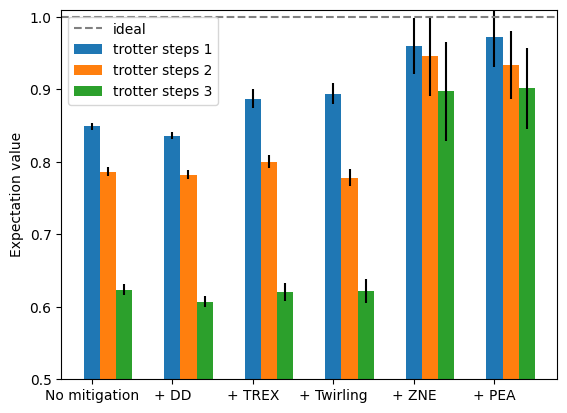

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
labels = ["No mitigation", "+ DD", "+ TREX", "+ Twirling", "+ ZNE", "+ PEA"]
width = 0.2

for trotter_step, session_id in zip([1,2,3], ['ctd3534y6ybg008tnj2g', 'ctd74gaakxxg008mrb70', 'ctd74pavdgb0008zh5j0']):

    # Retrieve session jobs
    jobs = service.jobs(session_id=session_id)[::-1] # Reverse order to match the order of the jobs
    #for job in jobs:
    #    print(job.job_id(), job.status())
        
    # Retrieve the job results
    results = [job.result() for job in jobs]

    # Unpack the PUB results (there's only one PUB result in each job result)
    pub_results = [result[0] for result in results]

    # Unpack the expectation values and standard errors
    expectation_vals = np.array([np.mean(np.array(pub_result.data.evs)) for pub_result in pub_results])
    standard_errors = np.array([np.mean(np.array(pub_result.data.stds)) for pub_result in pub_results])

    # Plot the expectation values
    ax.bar(np.arange(len(labels))+width*(trotter_step-1), expectation_vals, width = width, yerr=standard_errors, label="trotter steps {}".format(trotter_step))

ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")
ax.set_ylim(0.5, 1.01)

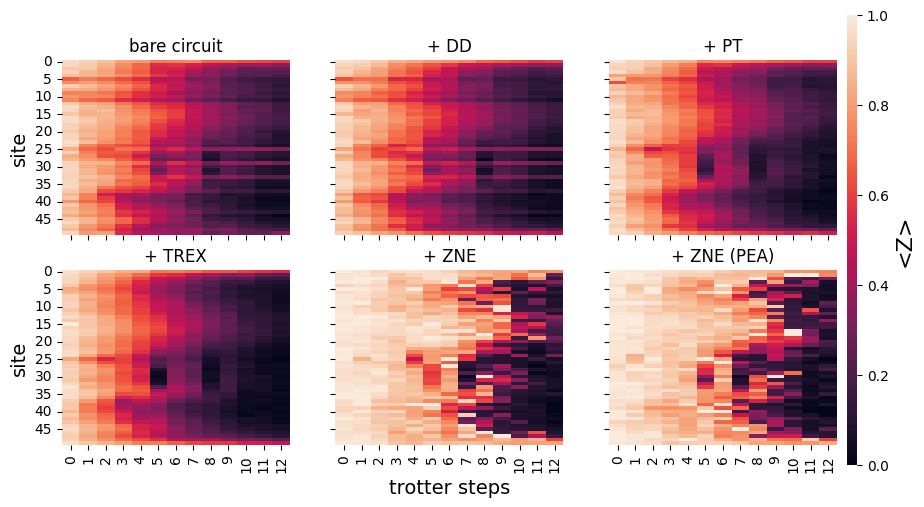

In [17]:
from seaborn import heatmap
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np

service = QiskitRuntimeService()

trotter_steps = 13
session_ids = ['ctgdrz3bpcr0008rvsd0', 'ctgds24zhysg008rwwwg', 'ctgds4w9fby0008fjbk0', 'ctgds7w9fby0008fjbp0', 'ctgdsanbpcr0008rvsf0', 'ctgdsdnr4vc0008a1g9g',
               'ctgdsgp9fby0008fjbs0', 'ctgdskps6dvg008azjxg', 'ctgdspe9fby0008fjbvg', 'ctgdssfbpcr0008rvsk0', 'ctgdswfr4vc0008a1ggg', 'ctgdszfq3n6g008fcq3g', 
               'ctgdt2gs6dvg008azk30', 'ctgdt58q3n6g008fcq60', 'ctgdt89q3n6g008fcq80']

fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(10, 5))

exp_val, exp_val_DD, exp_val_PT, exp_val_TREX, exp_val_ZNE, exp_val_PEA = [], [], [], [], [], []

for trotter_step in range(trotter_steps):

    session_id = session_ids[trotter_step]
    jobs = service.jobs(session_id=session_id)[::-1] # Reverse order to match the order of the jobs
    results = [job.result() for job in jobs]
    results = np.array([result[0].data.evs for result in results])
    exp_val.append(results[0])
    exp_val_DD.append(results[1])
    exp_val_PT.append(results[2])
    exp_val_TREX.append(results[3])
    exp_val_ZNE.append(results[4])
    exp_val_PEA.append(results[5])

cbar_ax = fig.add_axes([.91, .07, .01, .9])
hm = ((heatmap(np.array(exp_val).T, ax=axes[0][0], vmin=0, vmax=1, cbar_ax=cbar_ax),
      heatmap(np.array(exp_val_DD).T, ax=axes[0][1], vmin=0, vmax=1, cbar=None),
      heatmap(np.array(exp_val_PT).T, ax=axes[0][2], vmin=0, vmax=1, cbar=None)),
      (heatmap(np.array(exp_val_TREX).T,  ax=axes[1][0], vmin=0, vmax=1, cbar=None),
      heatmap(np.array(exp_val_ZNE).T,  ax=axes[1][1], vmin=0, vmax=1, cbar=None),
      heatmap(np.array(exp_val_PEA).T, ax=axes[1][2], vmin=0, vmax=1, cbar=None)))

axes[0][0].set_title('bare circuit')
axes[0][1].set_title('+ DD')
axes[0][2].set_title('+ PT')
axes[1][0].set_title('+ TREX')
axes[1][1].set_title('+ ZNE')
axes[1][2].set_title('+ ZNE (PEA)')
axes[1][1].set_xlabel('trotter steps', fontsize=14)
axes[0][0].set_ylabel('site', fontsize=14)
axes[1][0].set_ylabel('site', fontsize=14)
axes[0][0].collections[0].colorbar.set_label('<Z>', fontsize=16)